In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
from pathlib import Path
import copy
import logging
import sys

sys.path.insert(0, "ema_q_nonorm")
from train import get_params, get_transducer_model, load_checkpoint_if_available, get_parser

from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchao
import sentencepiece as spm
from lhotse.cut import CutSet
from lhotse.utils import LOG_EPSILON
import k2
from icefall.utils import add_sos
from icefall.lexicon import Lexicon
from icefall.utils import write_error_stats

from model import Transducer
from asr_datamodule import AsrDataModule

Skipping import of cpp extensions due to incompatible torch version 2.9.0+cu129 for torchao version 0.14.0         Please see GitHub issue #2919 for more info


In [3]:
parser = get_parser()
AsrDataModule.add_arguments(parser)
args = parser.parse_args([
    '--channels', '256',
    '--channels-expansion', '1024',
    '--dilations-version', '11',
    '--kernel-size', '8',
    '--encoder-dropout', '0.075',
    '--encoder-activation', 'SiLU',
    '--encoder-se-activation', 'SiLU',
    # '--encoder-norm', 'BatchNorm',
    '--decoder-dim', '256',
    '--joiner-dim', '256',
    # '--scale-limit', '2.0',
    '--ema-gamma', '0.97',  
    '--chunksize', '8',
    '--start-epoch', '180',
    '--exp-dir', 'exp/en/q_nonorm0_csg.95_silu',
    '--data-libri-train', 'True',
    '--data-libri-test-clean', 'True',
    '--manifest-dir', 'data/en/fbank',
    '--bpe-model', "data/en/lang_bpe_500/bpe.model",
])
args.exp_dir = Path(args.exp_dir)
params = get_params()
params.update(vars(args))

sp = spm.SentencePieceProcessor()
sp.load(params.bpe_model)
params.blank_id = sp.piece_to_id("<blk>")
params.unk_id = sp.piece_to_id("<unk>")
params.vocab_size = sp.get_piece_size()
logging.basicConfig(
    format="%(asctime)s %(levelname)s [%(filename)s:%(lineno)d] %(message)s",
    level=logging.INFO
)

In [4]:
params.blank_id, params.unk_id, params.vocab_size

(0, 2, 500)

In [4]:
model = get_transducer_model(params)
sd = torch.load("exp/en/q_nonorm_csg.95_silu/epoch-1-1-failed.pt", weights_only=False, map_location="cpu")
newsd = {}
for name, param in sd.items():
    newsd[name[7:]] = param
model.load_state_dict(newsd, strict=False)
model.eval()
model.cuda()
# load_checkpoint_if_available(params, model)

for name, param in model.named_parameters():
    if not torch.all(param.isfinite()):
        print(name)
for name, buffer in model.named_buffers():
    if not torch.all(buffer.isfinite()):
        print(name)
        # print(name, buffer)
        # break

encoder.cnn.8.se.sequential.3.weight_scale
encoder.cnn.8.se.sequential.3.std
encoder.cnn.9.se.sequential.1.weight_scale
encoder.cnn.9.se.sequential.1.std
encoder.cnn.9.se.sequential.3.weight_scale
encoder.cnn.9.se.sequential.3.std
encoder.cnn.9.norm.scale
encoder.cnn.10.pointwise1.weight_scale
encoder.cnn.10.pointwise1.std
encoder.cnn.10.depthwise.weight_scale
encoder.cnn.10.depthwise.std
encoder.cnn.10.pointwise2.weight_scale
encoder.cnn.10.pointwise2.std
encoder.cnn.10.se.sequential.1.weight_scale
encoder.cnn.10.se.sequential.1.std
encoder.cnn.10.se.sequential.3.weight_scale
encoder.cnn.10.se.sequential.3.std
encoder.cnn.10.norm.scale
encoder.proj.1.weight_scale
encoder.proj.1.std


In [12]:
# Prepare data
datamodule = AsrDataModule(params)
print(params.data_libri_test_clean)
test_dl_dict = datamodule.get_test_dataloader_dict(params)

2025-12-14 03:25:10,532 INFO [asr_datamodule.py:700] About to get test-clean cuts


True


In [5]:
IDX = 8

batch = torch.load("exp/en/q_nonorm_csg.95_silu/batch-bdd640fb-0667-1ad1-1c80-317fa3b1799d.pt", weights_only=False)
x = batch['inputs'].cuda()
x_len = batch['supervisions']['num_frames'].cuda()

with torch.no_grad():
    with torch.amp.autocast("cuda", enabled=True):
        enc = model.encoder
        x = nn.functional.pad(x, (0, 0, 4, 0), value=1.0e-10)
        x = (x - enc.mean) * enc.rstd
        x = x.transpose(1, 2)
        x, x_len = enc.conv_pre(x, x_len)
        
        for block in enc.cnn[:IDX]:
            x, x_len = block(x, x_len, 1.0)
        
        block = enc.cnn[IDX]
        x = block.pointwise1(x)
        x = block.depthwise(x)
        x = block.pointwise2(x)
        cs = block.se.chunksize
        T = x.size(2)
        pad = (T+cs-1) // cs * cs - T
        x = torch.nn.functional.pad(x, (0, pad))
        B, C, T_P = x.shape
        x = x.reshape(B, C, T_P // cs, cs).mean(dim=3)
        x = block.se.ema(x)
        x = block.se.sequential[1](x)

In [8]:
with torch.no_grad():
    with torch.amp.autocast("cuda", enabled=True):
        y = block.se.sequential[3](x)
        print(torch.all(torch.isfinite(x)), torch.all(torch.isfinite(y)))
        print((~y.sum(dim=(0, 2)).isfinite()).nonzero().view(-1))

tensor(True, device='cuda:0') tensor(False, device='cuda:0')
tensor([  5,  10,  17,  18,  20,  22,  33,  36,  39,  42,  45,  52,  60,  71,
         76,  92,  98,  99, 112, 115, 116, 133, 138, 144, 151, 158, 163, 167,
        184, 185, 195, 199, 203, 213, 218, 227, 238, 241], device='cuda:0')


[tensor(True), tensor(True), tensor(False)]


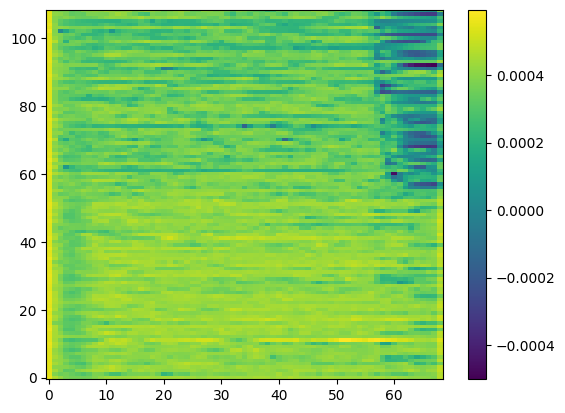

In [6]:
CH = 5
xin = newsd["encoder.cnn.8.se.sequential.3.input"]
w = newsd["encoder.cnn.8.se.sequential.3.weight_calculated"]
xout = newsd["encoder.cnn.8.se.sequential.3.output"]
print([torch.all(torch.isfinite(i)) for i in [xin, w, xout]])
im = plt.imshow(x[:, CH, :].detach().cpu().numpy(), origin="lower", interpolation="nearest", aspect="auto")
plt.colorbar(im)
plt.show()

In [8]:
x.shape, xin.shape

(torch.Size([109, 32, 69]), torch.Size([124, 32, 61]))

In [21]:
y1 = enc.cnn[IDX].pointwise1(x)
y2 = enc.cnn[IDX].depthwise(y1)
torch.all(torch.isfinite(y1)), torch.all(torch.isfinite(y2))

(tensor(True), tensor(False))

In [8]:
(~y2.sum(dim=(0, 2)).isfinite()).nonzero()

tensor([[264],
        [365],
        [418],
        [498],
        [569],
        [642],
        [766],
        [801]])

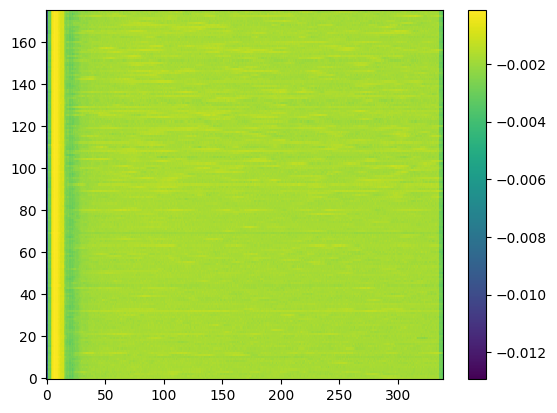

In [22]:
# y11 = torch.nn.functional.conv1d(x, enc.cnn[9].pointwise1.get_weight())
# im = plt.imshow(y11[:, 264, :].detach().cpu().numpy(), origin="lower", interpolation="nearest", aspect="auto")
im = plt.imshow(y1[:, 264, :].detach().cpu().numpy(), origin="lower", interpolation="nearest", aspect="auto")
plt.colorbar(im)
plt.show()

In [16]:
print(enc.cnn[9].pointwise1.weight_scale[264])
print(enc.cnn[9].depthwise.weight_scale[264])
print(enc.cnn[9].depthwise.weight_scale_prev[264].item())
print(enc.cnn[9].depthwise.std[264])

tensor([[2.4871]])
tensor([[nan]])
0.00011452566832304001
tensor(nan)


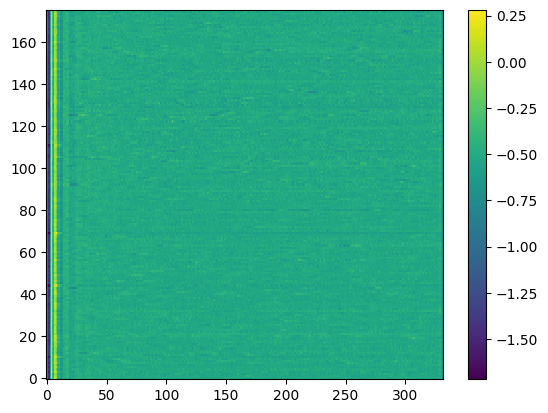

In [23]:
y22 = torch.nn.functional.conv1d(y1[:, 111:112, :], enc.cnn[9].depthwise.weight[111:112] / enc.cnn[9].depthwise.weight_scale_prev[111:112])#, enc.cnn[4].pointwise1.get_bias()[31:32])
im = plt.imshow(y22[:, 0, :].detach().cpu().numpy(), origin="lower", interpolation="nearest", aspect="auto")
plt.colorbar(im)
plt.show()

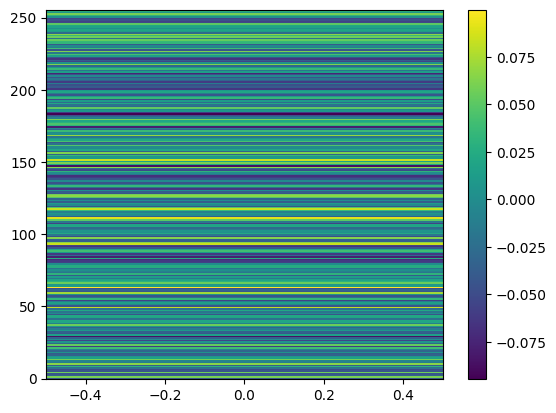

In [12]:
im = plt.imshow(enc.cnn[9].pointwise1.get_weight()[264].detach().cpu().numpy(), origin="lower", interpolation="nearest", aspect="auto")
plt.colorbar(im)
plt.show()

In [39]:
module = enc.cnn[4].pointwise1
print(module.weight.norm(dim=(1,2)).div(module.weight[0].numel()**0.5))
torch.isclose(module.weight.norm(dim=(1,2)).div(module.weight[0].numel()**0.5), torch.tensor([0.1]), atol=1.0e-3, rtol=1.0e-3).all()

tensor([0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
       grad_fn=<DivBackward0>)


tensor(True)

In [29]:
print(x.std(dim=(0,2)))

tensor([0.0970, 0.0885, 0.0670, 0.0512, 0.1971, 0.0701, 0.0721, 0.1833, 0.0821,
        0.1822, 0.1212, 0.1136, 0.1470, 0.0508, 0.2022, 0.0722, 0.1200, 0.2312,
        0.1566, 0.1341, 0.1139, 0.1187, 0.5320, 0.0811, 0.0774, 0.1163, 0.0972,
        0.1263, 0.0843, 0.0957, 0.1243, 0.1548, 0.0742, 0.0677, 0.1038, 0.0333,
        0.0947, 0.1401, 0.0875, 0.0753, 0.0919, 0.1934, 0.0891, 0.0721, 0.0948,
        0.1712, 0.0645, 0.1711, 0.0793, 0.0528, 0.0836, 0.1778, 0.2013, 0.1302,
        0.1090, 0.0616, 0.1336, 0.0910, 0.1894, 0.1609, 0.1907, 0.0976, 0.0817,
        0.0962, 0.0830, 0.1865, 0.2942, 0.1404, 0.2728, 0.0386, 0.0815, 0.0481,
        0.1189, 0.1319, 0.1005, 0.0612, 0.1179, 0.0932, 0.0713, 0.0789, 0.1019,
        0.0417, 0.0355, 0.0833, 0.1051, 0.0919, 0.0572, 0.0531, 0.1458, 0.1462,
        0.0696, 0.1030, 0.0509, 0.1438, 0.1060, 0.0970, 0.1292, 0.0886, 0.0770,
        0.0951, 0.1675, 0.1891, 0.1070, 0.1286, 0.1205, 0.0541, 0.1692, 0.0670,
        0.0894, 0.0931, 0.1735, 0.2318, 

In [8]:
w = block.se.sequential[1].get_weight()
b = block.se.sequential[1].get_bias()
print(w[1, :, 0])
print(b)
print(torch.nn.functional.conv1d(x, w)[0, 1])
print(block.se.sequential[1](x)[0, 1])

tensor([ 0.1081,  0.0275,  0.1197, -0.0803,  0.0361, -0.0483,  0.1174, -0.0760,
        -0.0880, -0.0705,  0.0422,  0.0232, -0.0538,  0.0382,  0.0780,  0.0558,
         0.0379, -0.0171,  0.1078, -0.0629, -0.0969, -0.0326, -0.0835,  0.0601,
        -0.0235,  0.0256,  0.0883, -0.0783, -0.0782, -0.0863, -0.1024, -0.0451,
        -0.0176, -0.0272,  0.0319, -0.0872,  0.0563, -0.0448,  0.0745,  0.0736,
        -0.0496, -0.1207, -0.0821, -0.0732,  0.0196,  0.0047, -0.1064,  0.0801,
        -0.0258, -0.0785, -0.0403, -0.0888,  0.0112,  0.0247,  0.1107, -0.0554,
        -0.0611, -0.0371, -0.0105, -0.0608,  0.0547,  0.0983, -0.0393, -0.0173,
        -0.0122, -0.0174,  0.0208, -0.0753, -0.1123, -0.1040,  0.0759, -0.0686,
        -0.0529, -0.0158,  0.1187,  0.0400,  0.0817, -0.0041,  0.0756,  0.0102,
        -0.0013,  0.0934,  0.0280, -0.0034, -0.0025, -0.0834,  0.0845,  0.0987,
         0.0344,  0.0834, -0.1212,  0.0123,  0.0331, -0.0482,  0.0131,  0.0278,
        -0.0487, -0.0727,  0.0040,  0.02

In [48]:
sd = torch.load("failed-scale-0.pt", weights_only=False, map_location="cpu")
x = sd["x"]
weight = sd["weight"]
weight_scale_prev = sd["weight_scale_prev"]
get_weight = sd["get_weight"]
get_bias = sd["get_bias"]
target = sd["target"]
weight_scale = sd["weight_scale"]

In [55]:
print(weight_scale_prev.view(-1)[645:650])
print(weight_scale.view(-1)[645:650])
print(target.view(-1)[645:650])
print((~weight_scale.view(-1).isfinite()).nonzero())

tensor([1.7382e-02, 1.7034e-02, 1.3246e-04, 3.2433e-01, 1.1983e-01])
tensor([0.0199, 0.0334,    nan, 0.4130, 0.1539])
tensor([0.0677, 0.3444,    nan, 2.0968, 0.8004])
tensor([[647]])


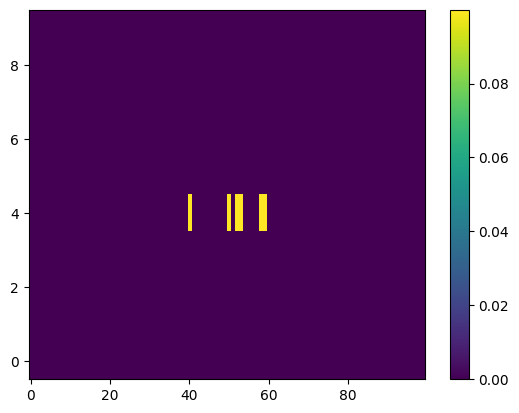

In [68]:
im = plt.imshow(x[110:120, 647, 50:150].clamp(max=0.1), origin="lower", interpolation="nearest", aspect="auto")
plt.colorbar(im)
plt.show()

In [36]:
x = torch.zeros(10, dtype=torch.float16)
x.std()

tensor(0., dtype=torch.float16)

In [13]:
for batch in test_dl_dict['librispeech-test-clean']:
    x = batch['inputs']
    x_len = batch['supervisions']['num_frames']

    enc = model.encoder
    x = nn.functional.pad(x, (0, 0, 4, 0), value=1.0e-10)
    x = (x - enc.mean) * enc.rstd
    x = x.transpose(1, 2)
    weight = enc.conv_pre.conv[1].weight
    x1 = nn.functional.conv1d(x, weight)
    print(x1.std(dim=(0,2)))
    x2 = enc.conv_pre.conv[1](x)
    print(x2.std(dim=(0,2)))
    break

tensor([0.5823, 0.9456, 0.6370, 0.7625, 0.8433, 0.6433, 0.9651, 1.0186, 0.7155,
        0.3539, 1.0276, 1.0913, 1.4984, 0.4458, 0.4706, 0.9703, 0.2828, 0.3749,
        1.2307, 0.8383, 1.6386, 0.5922, 1.9845, 0.3834, 0.4434, 1.0130, 0.4228,
        0.7921, 0.4680, 0.9733, 0.3522, 0.2500, 0.3877, 0.2426, 0.7017, 0.5298,
        0.3501, 0.3730, 0.5327, 0.9819, 1.2657, 0.4965, 0.4068, 0.4793, 0.9048,
        0.7189, 0.3152, 0.6971, 0.5152, 0.4516, 2.1464, 0.6435, 0.6135, 0.8399,
        0.3436, 1.3931, 0.4081, 0.4170, 0.6939, 0.9024, 0.9571, 0.3247, 0.9387,
        0.5086, 0.8385, 0.2962, 0.3787, 0.6811, 1.1539, 1.5882, 1.0723, 1.8504,
        0.3876, 0.9360, 0.5730, 0.5379, 0.3201, 0.6802, 0.7883, 0.4880, 0.6707,
        1.1760, 0.7036, 0.7047, 0.8967, 0.5018, 1.5101, 1.0160, 0.9164, 0.9263,
        1.1594, 0.3267, 1.3427, 0.6325, 1.7169, 0.2898, 0.4342, 0.3700, 0.3394,
        1.6927, 0.7295, 0.4347, 0.4455, 0.3796, 0.9524, 0.6434, 0.3699, 0.6969,
        0.4921, 0.3490, 0.4457, 1.0847, 

In [39]:
print(enc.conv_pre.conv[1].weight_scale.view(-1))

tensor([5.6058e-03, 3.3017e+00, 7.3303e-01, 5.2808e-03, 6.5026e+00, 2.4898e+00,
        5.4256e-03, 8.7463e-03, 3.6451e+00, 7.4711e+00, 3.5772e-01, 4.7315e-03,
        4.9694e+00, 4.7893e-03, 4.5365e+00, 5.1163e-03, 7.9261e-01, 5.2355e+00,
        6.7798e-01, 4.3367e-03, 1.6547e+00, 9.0038e-01, 7.1168e-03, 9.8704e-03,
        5.8964e-03, 3.6540e-03, 5.8322e-03, 7.2954e-01, 1.2062e+00, 4.8715e-03,
        2.7255e+00, 5.2440e-01, 6.1738e-01, 4.2517e-03, 7.1401e-03, 1.7967e+00,
        9.4146e-01, 2.2019e+00, 5.7927e-01, 6.5923e-03, 7.4576e-03, 7.2243e-01,
        1.8812e-02, 7.4727e-01, 4.5172e+00, 5.3998e-01, 7.4104e-01, 1.5265e+00,
        1.2614e+00, 1.1744e+00, 3.6668e-01, 6.5996e-01, 2.8416e+00, 3.6869e-03,
        1.2603e+00, 1.2385e+00, 1.1589e+00, 1.1171e+00, 1.1666e+00, 1.4953e+00,
        5.7275e-03, 7.2884e+00, 4.6103e-03, 9.3331e-01, 1.6090e+00, 5.7024e-03,
        5.8580e-03, 3.9962e-01, 5.4069e-01, 5.3958e-03, 1.6842e+00, 3.7487e-03,
        1.9879e+00, 4.7953e-01, 5.8636e-

In [41]:
w = enc.conv_pre.conv[1].weight
print(w.norm(dim=(1,2)) / w[0].numel() ** 0.5)
print(out)

tensor([0.0005, 0.0997, 0.0998, 0.0006, 0.0999, 0.0999, 0.0004, 0.0005, 0.1000,
        0.0992, 0.0987, 0.0005, 0.0998, 0.0006, 0.1000, 0.0005, 0.0998, 0.0998,
        0.0998, 0.0006, 0.0818, 0.0997, 0.0006, 0.0005, 0.0005, 0.0005, 0.0005,
        0.0998, 0.0999, 0.0005, 0.0998, 0.0999, 0.0996, 0.0005, 0.0005, 0.1000,
        0.0996, 0.0997, 0.0997, 0.0006, 0.0005, 0.0994, 0.0006, 0.0999, 0.0994,
        0.0997, 0.0999, 0.0994, 0.0997, 0.0999, 0.0894, 0.0999, 0.0996, 0.0004,
        0.0998, 0.0997, 0.0871, 0.0999, 0.0973, 0.0997, 0.0005, 0.0992, 0.0003,
        0.0999, 0.0997, 0.0006, 0.0004, 0.0996, 0.0998, 0.0005, 0.0989, 0.0003,
        0.0999, 0.0999, 0.0999, 0.1000, 0.0993, 0.0999, 0.1000, 0.0996, 0.0995,
        0.1000, 0.0999, 0.0990, 0.0998, 0.0005, 0.0999, 0.0999, 0.0999, 0.0005,
        0.0006, 0.0995, 0.0995, 0.0998, 0.0006, 0.0999, 0.1000, 0.1000, 0.0004,
        0.1000, 0.0999, 0.0993, 0.0999, 0.0005, 0.0004, 0.0006, 0.0004, 0.0004,
        0.0998, 0.0006, 0.0004, 0.0776, 

tensor(0.5637, grad_fn=<MaxBackward1>) tensor(0.0108, grad_fn=<MinBackward1>)


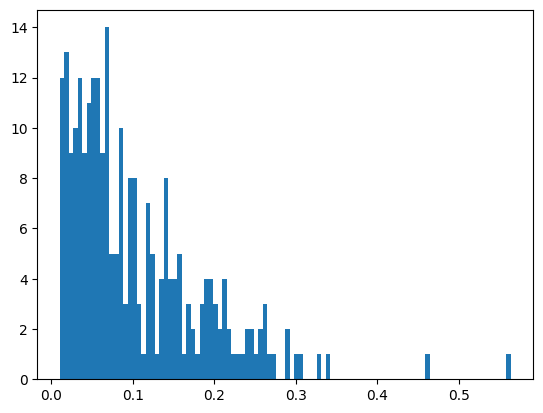

In [40]:
out = w.norm(dim=(1,2)) / w[0].numel() ** 0.5 / x1.std(dim=(0,2))
print(out.max(), out.min())
plt.hist(out.detach().cpu().numpy(), bins=100)
plt.show()

tensor(0.4976, grad_fn=<MaxBackward1>) tensor(0.0133, grad_fn=<MinBackward1>)


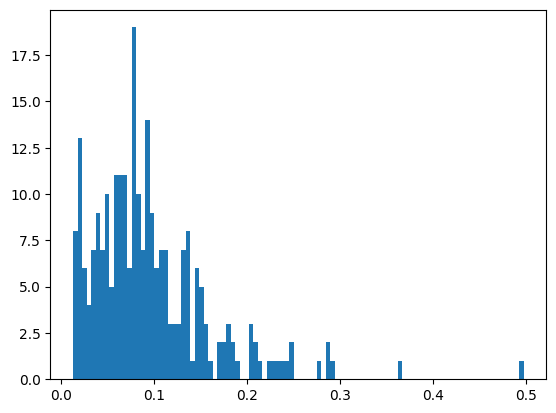

In [46]:
out = w.norm(dim=(1,2)) / w[0].numel() ** 0.5 / enc.conv_pre.conv[1].weight_scale.view(-1)
print(out.max(), out.min())
plt.hist(out.detach().cpu().numpy(), bins=100)
plt.show()

In [33]:
out = x2.std(dim=(0,2))
out.min(), out.max()

(tensor(0.3474, grad_fn=<MinBackward1>),
 tensor(2.5011, grad_fn=<MaxBackward1>))

In [45]:
x1.std(dim=(0,2)), enc.conv_pre.conv[1].weight_scale.view(-1)

(tensor([7.7686e-03, 3.9718e+00, 5.9231e-01, 8.0834e-03, 8.1110e+00, 2.6818e+00,
         1.2292e-02, 9.8235e-03, 4.2623e+00, 9.2142e+00, 3.2518e-01, 3.1550e-03,
         5.9398e+00, 9.4523e-03, 5.5274e+00, 6.7407e-03, 7.4842e-01, 6.5377e+00,
         5.8721e-01, 5.3854e-03, 1.9256e+00, 8.7323e-01, 1.6406e-02, 2.2963e-02,
         7.3401e-03, 4.7991e-03, 1.1693e-02, 5.5968e-01, 1.1345e+00, 4.4506e-03,
         3.1950e+00, 4.1826e-01, 5.1301e-01, 3.9214e-03, 7.1050e-03, 1.7757e+00,
         9.6044e-01, 2.5592e+00, 5.3090e-01, 5.7645e-03, 5.3758e-03, 6.2609e-01,
         1.8976e-02, 6.9811e-01, 5.5877e+00, 4.5764e-01, 5.4770e-01, 1.6641e+00,
         1.4637e+00, 1.2698e+00, 4.1975e-01, 6.4894e-01, 3.4317e+00, 8.2357e-03,
         1.4381e+00, 1.2655e+00, 9.8023e-01, 1.0953e+00, 9.9217e-01, 1.6732e+00,
         2.8617e-03, 9.1115e+00, 2.1047e-03, 8.3382e-01, 1.6839e+00, 1.0414e-02,
         1.0548e-02, 3.2323e-01, 4.7024e-01, 4.0177e-03, 2.1577e+00, 4.2762e-03,
         2.2969e+00, 4.0889e